# Walmart Sales Analysis

## Objective
The idea of this project is to practice turning raw data into insights that matter for a business.  
We’re looking at Walmart’s weekly sales data and asking: *what patterns can we find that would actually help a manager make decisions?*


## Business Questions
1. **Concentration:** How many stores are responsible for 50% and 80% of Walmart’s total sales?  
   → Why: If most sales come from just a few stores, those stores need more focus (inventory, promotions, staff).

2. **Holiday Impact:** Do sales really jump during holiday weeks, and by how much?  
   → Why: Managers can use this to plan ahead — schedule more workers and stock more products.

3. **Seasonality:** Which months or seasons bring in the most sales?  
   → Why: This helps understand yearly cycles and plan marketing campaigns.

4. **Trend Direction:** Over the years, are sales going up or down overall?  
   → Why: Shows whether demand is growing or cooling off in the long run.

5. **Macro Factors:** Do things like temperature, fuel price, CPI, or unemployment affect sales?  
   → Why: External conditions often change customer spending — good to know what matters most.


## Dataset
- **Source:** Kaggle — *Walmart Sales* dataset. (https://www.kaggle.com/datasets/mikhail1681/walmart-sales/data)
- **File Used:** `Walmart_Sales.csv`  

## Load Data

The goal here is just to **make sure the file loads correctly** and then **get a quick idea** of what’s inside.


In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Load CSV
df = pd.read_csv("../data/Walmart_Sales.csv")

# Look at the first few rows
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


**What this tells me**
- The dataset loaded correctly and columns match the business questions: `Store`, `Date`, `Weekly_Sales`, `Holiday_Flag`is binary (0/1) as expected, and macro factors (`Temperature`, `Fuel_Price`, `CPI`, `Unemployment`).
- Dates appear in `DD-MM-YYYY` format, so I’ll parse them to a proper datetime type before any time-series work.
- Values look reasonable for weekly sales.
- Columns already been named according to grouping/aggregation requirements and do not need to be renamed.

In [2]:
# Convert the Date column to proper datetime format (dataset uses dd-mm-YYYY)
df["Date"] = pd.to_datetime(df["Date"], format="%d-%m-%Y")

In [3]:
# Shape = (number of rows, number of columns)
print("Shape of dataset:", df.shape)

# Data types of each column
print("\n")
print("Column info:")
print(df.dtypes)

# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

Shape of dataset: (6435, 8)


Column info:
Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

Missing values per column:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [4]:
# Quick overview of min & max for all columns
df.describe().loc[["min", "max"]]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
min,1.0,2010-02-05 00:00:00,209986.25,0.0,-2.06,2.472,126.064000,3.879
max,45.0,2012-10-26 00:00:00,3818686.45,1.0,100.14,4.468,227.232807,14.313


In [5]:
# Count number of records per store
store_counts = df["Store"].value_counts().sort_index()
store_counts.describe()

count     45.0
mean     143.0
std        0.0
min      143.0
25%      143.0
50%      143.0
75%      143.0
max      143.0
Name: count, dtype: float64

In [6]:
# Check for the earliest and latest date per store
date_range_per_store = df.groupby("Store")["Date"].agg(["min", "max"])
date_range_per_store.head()  # Put 45 in the bracket to see all the rows

,min,max
Store,,
1,2010-02-05,2012-10-26
2,2010-02-05,2012-10-26
3,2010-02-05,2012-10-26
4,2010-02-05,2012-10-26
5,2010-02-05,2012-10-26


**What this tells me**
- The dataset contains **6,435 rows** and **8 columns**, each representing one store’s weekly sales record.  
- Columns are clean, `Date` is stored as a datetime object, and there are **no missing values**, so the dataset is analysis-ready.  
- There are **45 stores** in total, and each store has exactly **143 weekly records**, the time range spans from **February 2010 to October 2012**
- `Weekly_Sales` values range from **$209,986** to **$3,818,686**, showing significant variation across different stores or time periods.  
- The macroeconomic indicators (`Temperature`, `Fuel_Price`, `CPI`, and `Unemployment`) vary widely across this period, allowing us to later test how these external factors influence sales.  

## Feature Engineering

The goal here is to add time-based columns so grouping/plotting is easier (this is like adding helper columns in Excel).

In [7]:
# year, month, and ISO week number (1–53)
df["Year"]  = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)

# simple season label from month
def month_to_season(m):
    if m in (3, 4, 5): return "Spring"
    if m in (6, 7, 8): return "Summer"
    if m in (9, 10, 11): return "Fall"
    return "Winter"

df["Season"] = df["Month"].apply(month_to_season)

# Check
df[["Date","Year","Month","Week","Season"]].head()

,Date,Year,Month,Week,Season
0,2010-02-05,2010,2,5,Winter
1,2010-02-12,2010,2,6,Winter
2,2010-02-19,2010,2,7,Winter
3,2010-02-26,2010,2,8,Winter
4,2010-03-05,2010,3,9,Spring


In [8]:
# check table
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Season
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,Winter
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6,Winter
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7,Winter
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8,Winter
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9,Spring


**What this tells me**
- I successfully extracted new time-based features (`Year`, `Month`, `Week`, and `Season`) from the original `Date` column.  
- These helper columns make it much easier to group and visualize sales trends over time, the first few rows confirm the logic works correctly.


## Concentration

The goal here is to sort stores by total sales, then see how many stores we need to reach 50% and 80% of total revenue.

**Why 50% and 80%?**
- **50%** = “How many stores make up half of total sales?” Easy story for business partners.
- **80%** = Classic **Pareto 80/20** check. If a small number of stores reach 80%, sales are highly concentrated.

In [9]:
# Create a temporary SQL database in memory
con = sqlite3.connect(":memory:")

# Copy our DataFrame into SQL
df_sql = df.copy()
df_sql["Date"] = df_sql["Date"].dt.strftime("%Y-%m-%d")  # convert datetime to string for SQL
df_sql.to_sql("walmart_sales", con, index=False, if_exists="replace")

# Find the total sales per store
query_totals = """
SELECT Store, SUM(Weekly_Sales) AS total_sales
FROM walmart_sales
GROUP BY Store
ORDER BY total_sales DESC;
"""
store_totals = pd.read_sql(query_totals, con)
store_totals.head(10)

# Calculate cumulative share
store_totals["Cumulative_Sales"] = store_totals["total_sales"].cumsum()
total_sum = store_totals["total_sales"].sum()
store_totals["Cumulative_Share"] = store_totals["Cumulative_Sales"] / total_sum
store_totals.head(10)

# Find store numbers to reach 50% and 80%
n50 = (store_totals["Cumulative_Share"] < 0.5).sum() + 1  # +1 b/c start from 0
n80 = (store_totals["Cumulative_Share"] < 0.8).sum() + 1

print(f"Stores we needed to reach 50% of total sales: {n50}")
print(f"Stores we needed to reach 80% of total sales: {n80}")

cross_50 = store_totals.iloc[[n50 - 1]]
display(cross_50)

cross_80 = store_totals.iloc[[n80 - 1]]
display(cross_80)

# To double check
# store_totals.head(27)

top_50_stores = store_totals.iloc[:n50]["Store"].tolist()
print("The list of stores needed to reach 50%:")
print(top_50_stores)

top_80_stores = store_totals.iloc[:n80]["Store"].tolist()
print("The list of stores needed to reach 80%:")
print(top_80_stores)

Stores we needed to reach 50% of total sales: 14
Stores we needed to reach 80% of total sales: 27


,Store,total_sales,Cumulative_Sales,Cumulative_Share
13,24,1.940160e+08,3.429935e+09,0.509103


,Store,total_sales,Cumulative_Sales,Cumulative_Share
26,17,1.277821e+08,5.416591e+09,0.80398


The list of stores needed to reach 50%:
[20, 4, 14, 13, 2, 10, 27, 6, 1, 39, 19, 31, 23, 24]
The list of stores needed to reach 80%:
[20, 4, 14, 13, 2, 10, 27, 6, 1, 39, 19, 31, 23, 24, 11, 28, 41, 32, 18, 22, 12, 26, 34, 40, 35, 8, 17]


**What this tells me**
- Walmart’s revenue is heavily concentrated: **just 14 stores generate 50% of total sales**, and **27 stores account for 80%** of overall revenue.  
- This aligns with the **Pareto Principle (80/20 rule)**, showing that a small number of top-performing stores drive the majority of the company’s results. 

**This suggests that**  
- These top stores act as **core revenue drivers**, so any disruption (inventory shortages, staffing gaps, local competition) could have a major impact on company’s total sales.  
- Targeted investment in these locations through **marketing, logistics, technology, and customer experience improvements** could yield **outsized returns**.  
- The remaining stores can be analyzed for **operational optimization** to reduce performance gaps and strengthen the overall portfolio.

## Holiday Impact

The goal here is to understand how holidays impact Walmart’s weekly sales.

In [10]:
# Separate data into holiday and non-holiday weeks
holiday_sales = df[df["Holiday_Flag"] == 1]
non_holiday_sales = df[df["Holiday_Flag"] == 0]

# Display how many holiday and non-holiday weeks we have
print(f"Holiday weeks: {holiday_sales.shape[0]}")
print(f"Non-holiday weeks: {non_holiday_sales.shape[0]}")

# Calculate mean weekly sales
holiday_avg = holiday_sales["Weekly_Sales"].mean()
nonholiday_avg = non_holiday_sales["Weekly_Sales"].mean()

print(f"Average Weekly Sales during Holiday Weeks: ${holiday_avg:,.2f}")
print(f"Average Weekly Sales during Non-Holiday Weeks: ${nonholiday_avg:,.2f}")

Holiday weeks: 450
Non-holiday weeks: 5985
Average Weekly Sales during Holiday Weeks: $1,122,887.89
Average Weekly Sales during Non-Holiday Weeks: $1,041,256.38


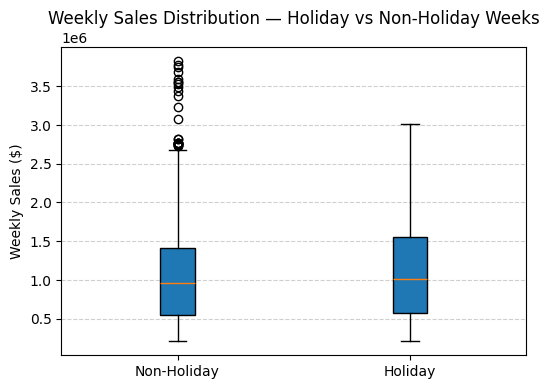

In [11]:
# Box plot
plt.figure(figsize=(6,4))
plt.boxplot(
    [non_holiday_sales["Weekly_Sales"], holiday_sales["Weekly_Sales"]],
    tick_labels=["Non-Holiday", "Holiday"],
    patch_artist=True
)
plt.title("Weekly Sales Distribution — Holiday vs Non-Holiday Weeks")
plt.ylabel("Weekly Sales ($)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


**What this tells me**
- On average, Walmart’s **holiday-week sales ($1.12M)** are **about 8% higher** than during **non-holiday weeks ($1.04M)**.
- The box plot shows **higher median sales** and **greater variability** during holidays, reflecting strong but less predictable consumer demand from major shopping events like **Black Friday, Christmas, and Thanksgiving**.
- This confirms that holidays have a **significant short-term impact on sales performance**, driving both revenue spikes and operational pressure.

**This suggests that**  
- **Customer demand spikes around holidays**, but also becomes less predictable.
- Walmart should **increase inventory, logistics, and staffing preparation** ahead of holiday periods to efficiently handle surges in demand.
- Well-timed promotions and early marketing campaigns can **maximize revenue capture** during these high-demand weeks.

## Seasonality

The goal here is to see how sales change throughout the year, by month and season.

In [12]:
# Monthly totals and averages
monthly_summary = (
    df.groupby("Month")["Weekly_Sales"]
      .agg(total_sales="sum", avg_sales="mean")
      .reset_index()
)

# Seasonal totals and averages
seasonal_summary = (
    df.groupby("Season")["Weekly_Sales"]
      .agg(total_sales="sum", avg_sales="mean")
      .reset_index()
)

print("Monthly Summary:")
print(monthly_summary.round(2))
print("\nSeasonal Summary:")
print(seasonal_summary.round(2))

Monthly Summary:
    Month   total_sales   avg_sales
0       1  3.325984e+08   923884.55
1       2  5.687279e+08  1053199.80
2       3  5.927859e+08  1013309.23
3       4  6.468598e+08  1026761.56
4       5  5.571256e+08  1031714.02
5       6  6.226299e+08  1064324.59
6       7  6.500010e+08  1031747.58
7       8  6.130902e+08  1048017.45
8       9  5.787612e+08   989335.35
9      10  5.847848e+08   999632.12
10     11  4.130157e+08  1147265.90
11     12  5.768386e+08  1281863.63

Seasonal Summary:
   Season   total_sales   avg_sales
0    Fall  1.576562e+09  1030432.48
1  Spring  1.796771e+09  1023801.29
2  Summer  1.885721e+09  1047622.82
3  Winter  1.478165e+09  1094937.01


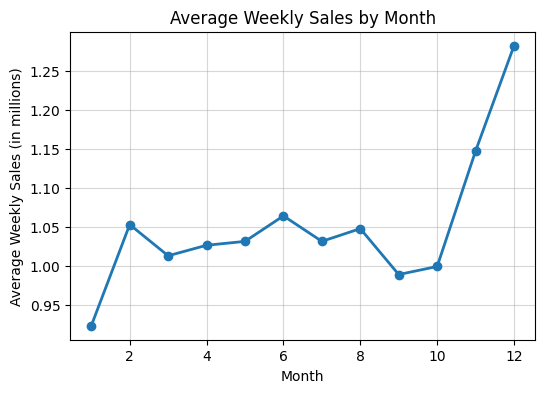

In [13]:
# Average Monthly Sales
plt.figure(figsize=(6,4))
plt.plot(monthly_summary["Month"], monthly_summary["avg_sales"]/1e6, marker="o", linewidth=2)
plt.title("Average Weekly Sales by Month")
plt.xlabel("Month")
plt.ylabel("Average Weekly Sales (in millions)")
plt.grid(alpha=0.5)
plt.show()

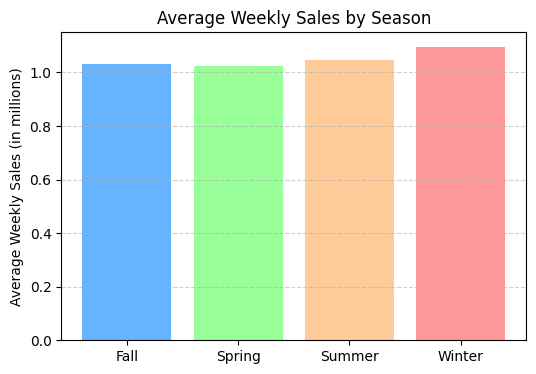

In [14]:
# Average Seasonal Sales
plt.figure(figsize=(6,4))
plt.bar(seasonal_summary["Season"], seasonal_summary["avg_sales"]/1e6,
        color=["#66b3ff","#99ff99","#ffcc99","#ff9999"])
plt.title("Average Weekly Sales by Season")
plt.ylabel("Average Weekly Sales (in millions)")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()


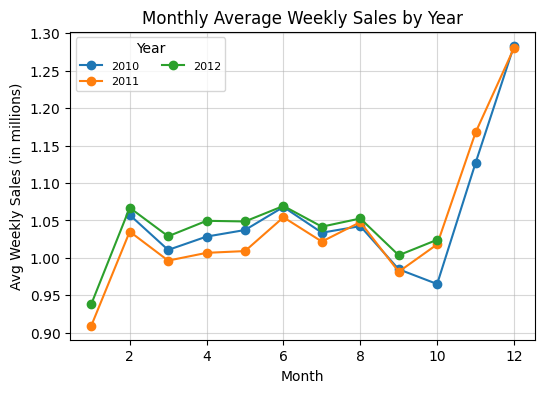

In [15]:
# Average weekly sales per year and month
year_month_avg = (
    df.groupby(["Year", "Month"])["Weekly_Sales"]
      .mean()
      .reset_index(name="avg_weekly_sales")
)

plt.figure(figsize=(6,4))
for year, data in year_month_avg.groupby("Year"):
    data = data.sort_values("Month")
    plt.plot(data["Month"], data["avg_weekly_sales"]/1e6, marker="o", label=str(year))

plt.title("Monthly Average Weekly Sales by Year")
plt.xlabel("Month")
plt.ylabel("Avg Weekly Sales (in millions)")
plt.legend(title="Year", ncol=2, fontsize=8)
plt.grid(alpha=0.5)
plt.show()


**What this tells me**
- Walmart’s sales show **clear seasonal and monthly patterns**, with **December peaking at $1.28M in average weekly sales**, nearly **40% higher than January**.  
- The winter season overall has the **highest average sales ($1.09M)**, confirming that year-end holidays and gift shopping significantly boost revenue.
- Meanwhile, **spring and fall remain stable**, suggesting steady baseline demand outside the peak months. 

**This suggests that**  
- Walmart should **prioritize inventory, marketing, and staffing** during Q4 to capture maximum revenue.  
- The company can use **Q1 slow periods** to clear excess inventory and prepare for new product launches.  
- Recognizing this pattern helps improve **forecasting accuracy** and **optimize resource allocation** across the year.

## Trend Direction

The goal here is to analyze how total or average sales change year by year, to identify long-term growth or decline.

In [16]:
# Group by year
yearly_sales = (
    df.groupby("Year")["Weekly_Sales"]
      .agg(total_sales="sum", avg_sales="mean")
      .reset_index()
)

print(yearly_sales.round(2))


   Year   total_sales   avg_sales
0  2010  2.288886e+09  1059669.50
1  2011  2.448200e+09  1046239.32
2  2012  2.000133e+09  1033660.39


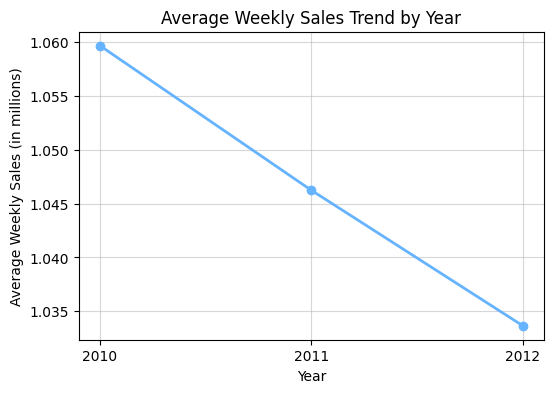

In [17]:
# Average weekly sales by years
plt.figure(figsize=(6,4))
plt.plot(yearly_sales["Year"].astype(str), yearly_sales["avg_sales"]/1e6,
         marker="o", linewidth=2, color="#66b3ff")
plt.title("Average Weekly Sales Trend by Year")
plt.xlabel("Year")
plt.ylabel("Average Weekly Sales (in millions)")
plt.grid(alpha=0.5)
plt.show()

**What this tells me**  
- Walmart’s **average weekly sales declined slightly** from **$1.06M in 2010** to **$1.03M in 2012**, showing a **gradual downward trend** over time, possibly due to market saturation or changing consumer behavior.

**This suggests that**  
- Walmart should **analyze category-level and regional trends** to identify where growth is stagnating.  
- **Operational improvements and marketing efforts** could be targeted toward underperforming areas to reverse the slowdown.

## Macro Factors

The goal here is to see how temperature, fuel price, CPI, or unemployment affect sales.

In [18]:
# Compute correlation coefficient
macro_vars = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]

corr = (
    df[["Weekly_Sales"] + macro_vars]
        .corr()
        ["Weekly_Sales"]
        .drop("Weekly_Sales")
        .round(3)
)

print("Correlation between Weekly Sales and Macro Factors:")
print(corr)

Correlation between Weekly Sales and Macro Factors:
Temperature    -0.064
Fuel_Price      0.009
CPI            -0.073
Unemployment   -0.106
Name: Weekly_Sales, dtype: float64


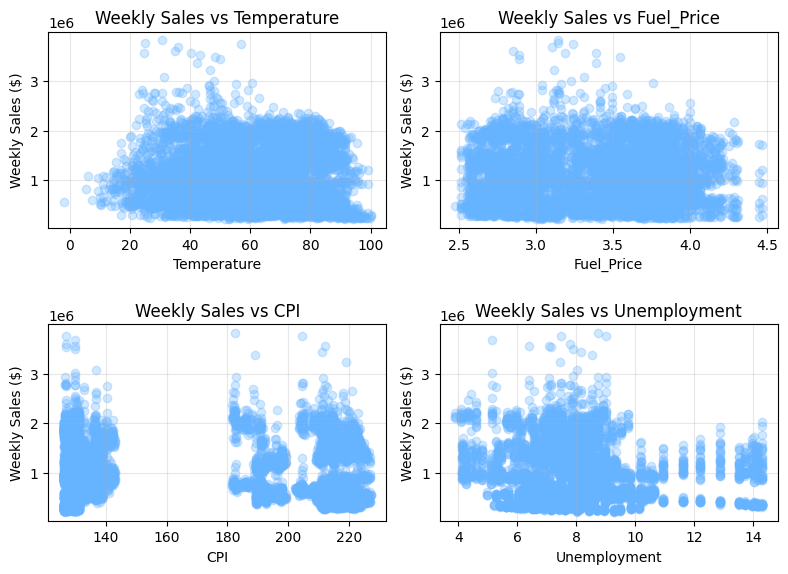

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(8,6))
axes = axes.flatten()

for i, col in enumerate(macro_vars):
    axes[i].scatter(df[col], df["Weekly_Sales"], alpha=0.3, color="#66b3ff")
    axes[i].set_title(f"Weekly Sales vs {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Weekly Sales ($)")
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**What this tells me**  
- None of the macroeconomic variables show a strong correlation with sales:  
  - **Unemployment (-0.106)**, **Temperature (-0.064)** and **CPI (-0.073)** have weak negative relationships.  
  - **Fuel Price (0.009)** shows virtually no relationship with weekly sales.  
- This indicates that **Walmart’s sales remain relatively stable**, even when external economic indicators fluctuate.
- The scatter plots confirm there is **no clear linear trend**, suggesting demand is more driven by internal or seasonal factors than by macroeconomic shifts.  

**This suggests that**  
- Walmart’s **business model is resilient** to short-term macroeconomic changes, likely due to its focus on **essential goods and value pricing**.  
- Strategic planning should continue to focus on **operational efficiency and pricing strategy**, rather than over-relying on predicting macroeconomic fluctuation.
- Tracking **unemployment and CPI trends** can still help anticipate subtle shifts in **consumer purchasing power**.

## Summary & Conclusion  

**Key Insights**
- Walmart’s sales show **clear seasonality**, peaking in **December** and dipping in early-year months.  
- **Holiday weeks boost sales by about 8%**, highlighting strong event-driven demand.  
- Revenue is **highly concentrated**, with **27 stores generating 80%** of total sales.
- **Macro factors (CPI, Fuel Price, Unemployment)** have minimal correlation with sales, Walmart’s performance remains **largely resilient to economic fluctuations**.  
- The **yearly average sales trend** shows mild decline, indicating stable but slowing growth momentum.  

**Business Recommendations**
- Walmart should **leverage high-performing stores** through targeted investment and resource optimization.  
- **Holiday and Q4 planning** are key opportunities for maximizing profitability.  
- During off-peak seasons, **inventory management and promotional activities** can help maintain steady revenue.  
- While macroeconomic shifts have limited short-term impact, **long-term monitoring** can help Walmart anticipate changes in consumer behavior and adjust pricing strategies.